In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np



In [ ]:
!pip install kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [183]:
!kaggle datasets download -d kyanyoga/sample-sales-data
!unzip dataset-name.zip

Dataset URL: https://www.kaggle.com/datasets/kyanyoga/sample-sales-data
License(s): CC0-1.0
sample-sales-data.zip: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open dataset-name.zip, dataset-name.zip.zip or dataset-name.zip.ZIP.


**Loading** **the** **Data**

In [184]:
import pandas as pd

# Load dataset
sales = pd.read_csv('/content/sales_data_sample.csv' , encoding = 'unicode_escape')
sales.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


The dataset has 2823 rows and 25 columns.

**Cleaning the Data**

Identifying and handling duplicate and missing Data

In [ ]:
sales.duplicated().sum()

0

We dont have any duplicate data

In [ ]:
#Check NUll Values
isnull=pd.DataFrame(sales.isnull().sum())
isnull.style.background_gradient(cmap='Blues')

,0
ORDERNUMBER,0
QUANTITYORDERED,0
PRICEEACH,0
ORDERLINENUMBER,0
SALES,0
ORDERDATE,0
STATUS,0
QTR_ID,0
MONTH_ID,0
YEAR_ID,0


**Dimension Reduction by Feature selection**



After identifying the number of missing data points, it's time to clean our dataset. Some columns do not play a role in our data analysis, so we will remove them. For example, columns like PHONE, POSTALCODE, ORDERNUMBER, and PRODUCTCODE. Some columns, such as CUSTOMERNAME, CONTACTLASTNAME, AND CONTANCTFIRSTNAME, as we are not analyzing individual customer behavior, then we don't need them. Additionally, the ADDRESSLINE2 column, which is mostly empty, can either be combined with the ADDRESSLINE1 column or removed entirely. We will decide later regarding the STATE and TERRITORY columns.


In [ ]:
sales = sales.drop(['ORDERNUMBER', 'PRODUCTCODE', 'PHONE', 'ADDRESSLINE2','POSTALCODE','CONTACTFIRSTNAME', 'CONTACTLASTNAME','CUSTOMERNAME'], axis=1)

In [ ]:
sales.head(2823)

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,ADDRESSLINE1,CITY,STATE,COUNTRY,TERRITORY,DEALSIZE
0,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,Motorcycles,95,897 Long Airport Avenue,NYC,NY,USA,NaN,Small
1,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,Motorcycles,95,59 rue de l'Abbaye,Reims,NaN,France,EMEA,Small
2,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,Motorcycles,95,27 rue du Colonel Pierre Avia,Paris,NaN,France,EMEA,Medium
3,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,Motorcycles,95,78934 Hillside Dr.,Pasadena,CA,USA,NaN,Medium
4,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,95,7734 Strong St.,San Francisco,CA,USA,NaN,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,12/2/2004 0:00,Shipped,4,12,2004,Ships,54,"C/ Moralzarzal, 86",Madrid,NaN,Spain,EMEA,Small
2819,29,100.00,1,3978.51,1/31/2005 0:00,Shipped,1,1,2005,Ships,54,Torikatu 38,Oulu,NaN,Finland,EMEA,Medium
2820,43,100.00,4,5417.57,3/1/2005 0:00,Resolved,1,3,2005,Ships,54,"C/ Moralzarzal, 86",Madrid,NaN,Spain,EMEA,Medium
2821,34,62.24,1,2116.16,3/28/2005 0:00,Shipped,1,3,2005,Ships,54,1 rue Alsace-Lorraine,Toulouse,NaN,France,EMEA,Small


In [ ]:
#Look into current Territory Label
print('Current territory label:')
sales['TERRITORY'].unique()

Current territory label:


array([nan, 'EMEA', 'APAC', 'Japan'], dtype=object)

**Identify Countries where the 'TERRITORY' column is NaN**

In [ ]:
nan_territory_df = sales[sales['TERRITORY'].isna()]

countries_with_nan_territory = nan_territory_df['COUNTRY'].unique()

print(countries_with_nan_territory)

['USA' 'Canada']


The USA and Canada are the two countries where the Territory column had Null Values. Fill it up become easier as they both belong to the same Territory "NA" for North America

In [ ]:
sales["TERRITORY"] = sales["TERRITORY"].fillna("NA")

**Identify Countries where the 'State' column is NaN**

In [ ]:
nan_state = sales[sales["STATE"].isna()]

countries_with_nan_state = nan_state['COUNTRY'].unique()

print(countries_with_nan_state)

['France' 'Norway' 'Finland' 'Austria' 'UK' 'Spain' 'Sweden' 'Singapore'
 'Italy' 'Denmark' 'Belgium' 'Philippines' 'Germany' 'Switzerland'
 'Ireland']


There are many countries with Null Value State Column and accurately predicting which exact State in the Country will be almost impossible. So I will look at the descriptive statistics and drop the State Column.

In [ ]:
state_sales = sales.groupby('STATE')['SALES'].describe()
print(state_sales)


               count         mean          std      min        25%       50%  \
STATE                                                                          
BC              48.0  3122.370208  1461.607248  1119.93  2102.9550  2912.880   
CA             416.0  3619.091899  1945.958755   541.14  2203.0750  3244.970   
CT              61.0  3912.480000  1950.273355   875.91  2390.2200  3515.670   
Isle of Wight   26.0  3009.263077  1135.546231  1192.56  2198.8150  2833.695   
MA             190.0  3507.598526  1781.228452   651.80  2257.0550  3186.810   
NH              34.0  3873.097059  2172.321979   917.70  2406.1625  3512.415   
NJ              21.0  3963.247143  2025.277922  1135.31  2389.6000  3659.020   
NSW             92.0  3321.381630  1608.443683   652.35  2222.6675  3127.825   
NV              29.0  2853.485517  1319.896240   995.50  1713.8000  2604.520   
NY             178.0  3631.144719  1805.924828   905.28  2280.5925  3225.860   
Osaka           20.0  3380.253500  1540.

In [ ]:
sales = sales.drop('STATE',axis=1)

After looking through the State Descriptive Statistics, I droped the State Column

In [ ]:
sales.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,ADDRESSLINE1,CITY,COUNTRY,TERRITORY,DEALSIZE
0,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,Motorcycles,95,897 Long Airport Avenue,NYC,USA,NA,Small
1,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,Motorcycles,95,59 rue de l'Abbaye,Reims,France,EMEA,Small
2,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,Motorcycles,95,27 rue du Colonel Pierre Avia,Paris,France,EMEA,Medium
3,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,Motorcycles,95,78934 Hillside Dr.,Pasadena,USA,NA,Medium
4,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,95,7734 Strong St.,San Francisco,USA,NA,Medium


**Confirming the State Column has been properly dropped and we don't have null values**


In [ ]:
sales.isnull().sum()


QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
ORDERDATE          0
STATUS             0
QTR_ID             0
MONTH_ID           0
YEAR_ID            0
PRODUCTLINE        0
MSRP               0
ADDRESSLINE1       0
CITY               0
COUNTRY            0
TERRITORY          0
DEALSIZE           0
dtype: int64


### **Observations:**
>1. There are no duplicates in the data
>2. For column contains null values, I focus on: territory and state
>> * territory:
>>>  * Only '[nan, 'EMEA', 'APAC', 'Japan']' are built in territory labels
>>>  *  'NaN' is just for USA and Canada; both of them belong to 'AMER' terrority then we replaced NaN with NA in our dataset.
>> * state:
>>>  * There are many countries with Null Value State Column

>3. In a nutshell, when analyze geographically we can look into 'country' and 'city' rather than territory and state
>4. Future work:
>> * Asking stakeholders(sales/operation team) to update the territory label ex. adding US or North America.
>> * Save the null data, and ask stakeholders to update the state-missing label

## **Standardizing Data Format**
Convert ORDERDATE to datetime

In [ ]:
sales['ORDERDATE'] = pd.to_datetime(sales['ORDERDATE'])

###Ensure numerical columns are of appropriate type


In [ ]:
sales['QUANTITYORDERED'] = sales['QUANTITYORDERED'].astype(int)
sales['PRICEEACH'] = sales['PRICEEACH'].astype(float)
sales['SALES'] = sales['SALES'].astype(float)

###Standardize text fields

In [ ]:
sales['ADDRESSLINE1'] = sales['ADDRESSLINE1'].str.strip()
sales['CITY'] = sales['CITY'].str.strip().str.title()
sales['COUNTRY'] = sales['COUNTRY'].str.strip().str.upper()
sales['DEALSIZE'] = sales['DEALSIZE'].str.strip().str.capitalize()
sales['TERRITORY'] = sales['TERRITORY'].str.strip().str.upper()


sales.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,ADDRESSLINE1,CITY,COUNTRY,TERRITORY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,897 Long Airport Avenue,Nyc,USA,NA,Small
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,59 rue de l'Abbaye,Reims,FRANCE,EMEA,Small
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,27 rue du Colonel Pierre Avia,Paris,FRANCE,EMEA,Medium
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,78934 Hillside Dr.,Pasadena,USA,NA,Medium
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,7734 Strong St.,San Francisco,USA,NA,Medium


###Now we have clean our data, lets check the descriptive statistics

In [ ]:
sales.describe()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP
count,2823.000000,2823.000000,2823.000000,2823.000000,2823,2823.000000,2823.000000,2823.00000,2823.000000
mean,35.092809,83.658544,6.466171,3553.889072,2004-05-11 00:16:49.989373056,2.717676,7.092455,2003.81509,100.715551
min,6.000000,26.880000,1.000000,482.130000,2003-01-06 00:00:00,1.000000,1.000000,2003.00000,33.000000
25%,27.000000,68.860000,3.000000,2203.430000,2003-11-06 12:00:00,2.000000,4.000000,2003.00000,68.000000
50%,35.000000,95.700000,6.000000,3184.800000,2004-06-15 00:00:00,3.000000,8.000000,2004.00000,99.000000
75%,43.000000,100.000000,9.000000,4508.000000,2004-11-17 12:00:00,4.000000,11.000000,2004.00000,124.000000
max,97.000000,100.000000,18.000000,14082.800000,2005-05-31 00:00:00,4.000000,12.000000,2005.00000,214.000000
std,9.741443,20.174277,4.225841,1841.865106,NaN,1.203878,3.656633,0.69967,40.187912


Now its time to clustring our dataset.

### Clustering and Feature Selection for Sales Data

In this section, we will perform clustering on the sales dataset using key features: `SALES`, `QUANTITYORDERED`, and `PRICEEACH`. These features have been selected based on their relevance to the sales performance and product demand. Clustering will help us identify patterns and group similar sales transactions, which can be useful for market segmentation and targeted marketing strategies.

#### Feature Selection
- **SALES**: This feature represents the total sales amount for each transaction. It is a direct measure of revenue and is crucial for understanding the financial performance.
- **QUANTITYORDERED**: This feature indicates the number of units ordered in each transaction. It helps in understanding the demand for different products.
- **PRICEEACH**: This feature shows the price per unit of the products sold. It is important for analyzing pricing strategies and its impact on sales.

These features are interrelated, as the total sales amount (SALES) is derived from the product of the quantity ordered (QUANTITYORDERED) and the price per unit (PRICEEACH). Therefore, they collectively provide a comprehensive view of the sales transactions.

#### Clustering Approach
We will use the K-Means clustering algorithm to group the sales transactions based on the selected features. K-Means is a popular clustering method that aims to partition the dataset into K clusters, where each transaction belongs to the cluster with the nearest mean. This method is particularly useful for our dataset as it helps in identifying distinct segments within the sales data.

#### Steps for Clustering
1. **Data Preprocessing**: Standardize the selected features to ensure that they have a mean of zero and a standard deviation of one. This step is crucial as it ensures that all features contribute equally to the clustering process.
2. **K-Means Clustering**: Apply the K-Means algorithm with a predefined number of clusters (K). We will experiment with different values of K to determine the optimal number of clusters using the Elbow method and Silhouette Score.
3. **Cluster Analysis**: Analyze the resulting clusters to understand the characteristics of each group. This analysis will include examining the centroids of the clusters and the distribution of transactions within each cluster.

By performing clustering on the sales dataset, we aim to uncover hidden patterns and group similar transactions. This analysis will provide valuable insights into customer behavior, product performance, and pricing strategies, ultimately aiding in more informed business decisions.

In [ ]:
# Select features for clustering
features = sales[['SALES', 'QUANTITYORDERED','PRICEEACH']]

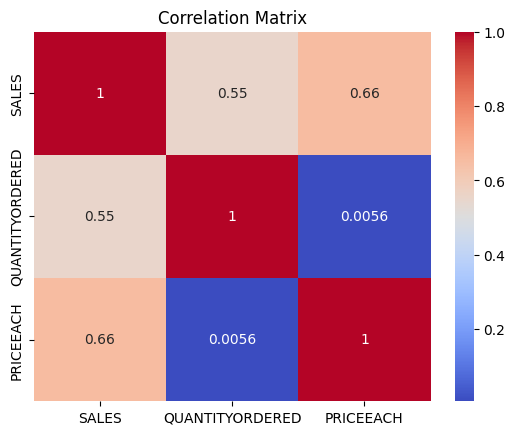

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculating correlatin matrix
correlation_matrix = features.corr()

# Plotting Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


### Elbow Method for Optimal K

The Elbow Method helps determine the optimal number of clusters (K) in K-Means clustering. By plotting the sum of squared distances (inertia) against the number of clusters, we identify the "elbow" point where the rate of decrease slows down. This point indicates a balance between minimizing inertia and avoiding overfitting, suggesting the optimal K.

Steps:
1. Run K-Means for a range of K values.
2. Plot inertia for each K.
3. Identify the "elbow" point.

This method ensures meaningful clustering without overfitting.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

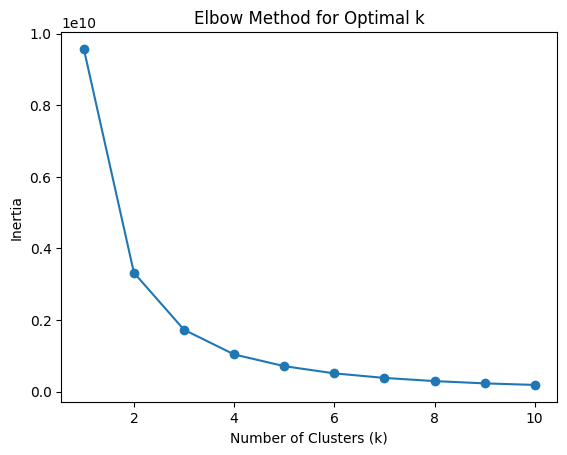

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Elbow method to find optimal k
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_) # SSE OR WCSS

# Plot the elbow method graph
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


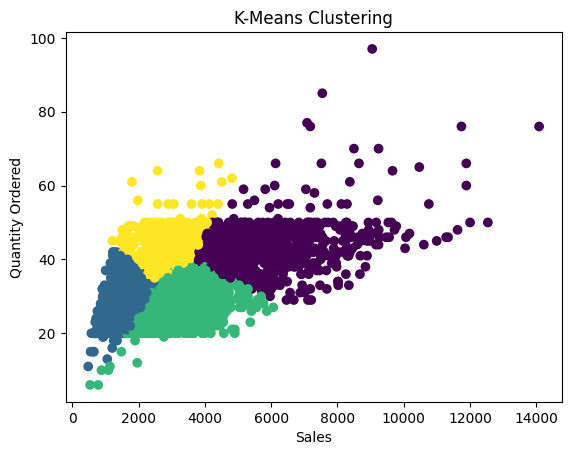

In [ ]:

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans clustering with optimal k
kmeans = KMeans(n_clusters=4)
kmeans.fit(scaled_features)

# Adding clusters' lable to DataFrame
sales['Cluster'] = kmeans.labels_

# Plotting clusters
plt.scatter(sales['SALES'], sales['QUANTITYORDERED'], c=sales['Cluster'], cmap='viridis')
plt.xlabel('Sales')
plt.ylabel('Quantity Ordered')
plt.title('K-Means Clustering')
plt.show()

In [ ]:
sales.head(2823)

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,ADDRESSLINE1,CITY,COUNTRY,TERRITORY,DEALSIZE,Cluster
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,897 Long Airport Avenue,Nyc,USA,NA,Small,2
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,59 rue de l'Abbaye,Reims,FRANCE,EMEA,Small,2
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,27 rue du Colonel Pierre Avia,Paris,FRANCE,EMEA,Medium,0
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,78934 Hillside Dr.,Pasadena,USA,NA,Medium,3
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,7734 Strong St.,San Francisco,USA,NA,Medium,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,Shipped,4,12,2004,Ships,54,"C/ Moralzarzal, 86",Madrid,SPAIN,EMEA,Small,2
2819,29,100.00,1,3978.51,2005-01-31,Shipped,1,1,2005,Ships,54,Torikatu 38,Oulu,FINLAND,EMEA,Medium,2
2820,43,100.00,4,5417.57,2005-03-01,Resolved,1,3,2005,Ships,54,"C/ Moralzarzal, 86",Madrid,SPAIN,EMEA,Medium,0
2821,34,62.24,1,2116.16,2005-03-28,Shipped,1,3,2005,Ships,54,1 rue Alsace-Lorraine,Toulouse,FRANCE,EMEA,Small,1


        SALES  QUANTITYORDERED  PRICEEACH  COUNTRY_AUSTRALIA  COUNTRY_AUSTRIA  \
0     2871.00               30      95.70              False            False   
1     2765.90               34      81.35              False            False   
2     3884.34               41      94.74              False            False   
3     3746.70               45      83.26              False            False   
4     5205.27               49     100.00              False            False   
...       ...              ...        ...                ...              ...   
2818  2244.40               20     100.00              False            False   
2819  3978.51               29     100.00              False            False   
2820  5417.57               43     100.00              False            False   
2821  2116.16               34      62.24              False            False   
2822  3079.44               47      65.52              False            False   

      COUNTRY_BELGIUM  COUN

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


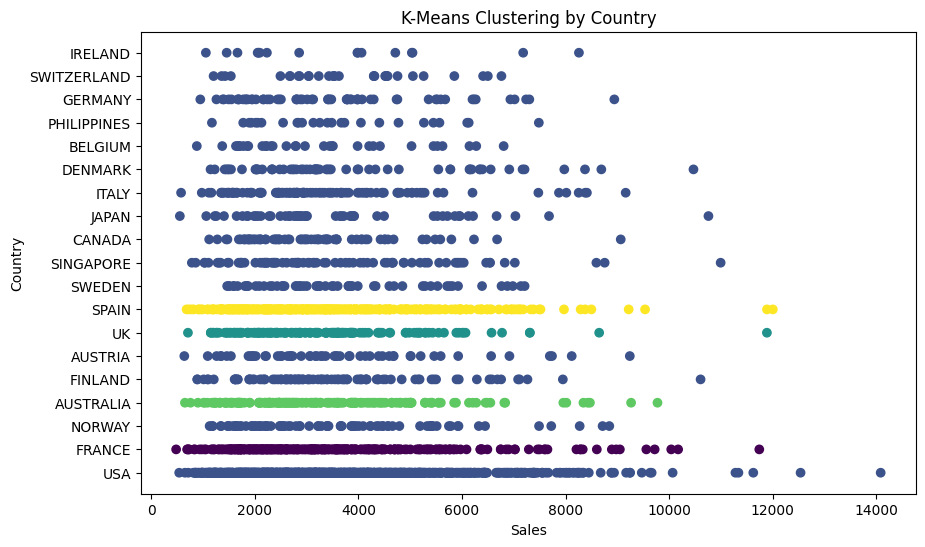

In [ ]:
# Select relevant features
features = sales[['COUNTRY', 'SALES', 'QUANTITYORDERED', 'PRICEEACH']]

# Convert categorical features to one hot encoding
features_encoded = pd.get_dummies(features, columns=['COUNTRY'])
print(features_encoded)

from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scaled_features1 = scaler.fit_transform(features_encoded)

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Running K-Means with a chosen number of clusters (e.g., 5)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(scaled_features1)

# Add cluster labels to the DataFrame
sales['Cluster1'] = kmeans.labels_

# Analyze and visualize results
plt.figure(figsize=(10, 6))
plt.scatter(sales['SALES'], sales['COUNTRY'], c=sales['Cluster1'], cmap='viridis')
plt.xlabel('Sales')
plt.ylabel('Country')
plt.title('K-Means Clustering by Country')
plt.show()


In [ ]:
sales.head(100)


,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,ADDRESSLINE1,CITY,COUNTRY,TERRITORY,DEALSIZE,Cluster,Cluster1
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,897 Long Airport Avenue,Nyc,USA,NA,Small,2,1
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,59 rue de l'Abbaye,Reims,FRANCE,EMEA,Small,2,0
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,27 rue du Colonel Pierre Avia,Paris,FRANCE,EMEA,Medium,0,0
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,78934 Hillside Dr.,Pasadena,USA,NA,Medium,3,1
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,7734 Strong St.,San Francisco,USA,NA,Medium,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,27,100.00,8,5438.07,2004-08-27,Shipped,3,8,2004,Motorcycles,193,39323 Spinnaker Dr.,Cambridge,USA,NA,Medium,2,1
96,29,100.00,11,6683.34,2004-09-30,Shipped,3,9,2004,Motorcycles,193,Keskuskatu 45,Helsinki,FINLAND,EMEA,Medium,0,1
97,20,100.00,1,4570.40,2004-10-15,Shipped,4,10,2004,Motorcycles,193,3758 North Pendale Street,White Plains,USA,NA,Medium,2,1
98,37,100.00,3,7667.14,2004-11-02,Shipped,4,11,2004,Motorcycles,193,7586 Pompton St.,Allentown,USA,NA,Large,0,1


##We'll use PCA for dimensionality reduction

- **PCA (Principal Component Analysis)** is a technique used to reduce the dimensionality of data by finding a new set of uncorrelated variables (principal components) that capture most of the variance in the original data.

- **Standardization:** It is often recommended to standardize the features before applying PCA. This ensures that all features have zero mean and unit variance, preventing features with larger scales from dominating the analysis.

- **Number of Components:** The `n_components` parameter in PCA determines the number of principal components to retain. This choice can be based on the explained variance ratio (how much of the total variance is captured by the selected components) or the desired level of dimensionality reduction.

- **Fitting and Transformation:** The `fit` method of the PCA object calculates the principal components from the input data. The `transform` method then projects the data onto the lower-dimensional space defined by these components.

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Selecting numeric columns for PCA
features = sales.select_dtypes(include=[np.number])

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
reduced_features = pca.fit_transform(features)

# Add reduced features back to the dataframe
sales['PCA1'] = reduced_features[:, 0]
sales['PCA2'] = reduced_features[:, 1]

# Display the first few rows to verify
sales[['PCA1', 'PCA2']].head()
sales.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,ADDRESSLINE1,CITY,COUNTRY,TERRITORY,DEALSIZE,Cluster,Cluster1,PCA1,PCA2
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,897 Long Airport Avenue,Nyc,USA,NA,Small,2,1,-682.809560,-8.345591
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,59 rue de l'Abbaye,Reims,FRANCE,EMEA,Small,2,0,-787.988476,-5.655064
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,27 rue du Colonel Pierre Avia,Paris,FRANCE,EMEA,Medium,0,0,330.428038,8.354190
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,78934 Hillside Dr.,Pasadena,USA,NA,Medium,3,1,192.732923,9.837339
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,7734 Strong St.,San Francisco,USA,NA,Medium,0,1,1651.250671,27.508291


### Sensitivity Analysis for KMeans Clustering Hyperparameter

This section performs a sensitivity analysis on the KMeans model to determine the optimal number of clusters (k). I will evaluate the model's performance using Inertia and Silhouette Score for a range of k values.

**Steps:**

1. **Define a range of k values (2 to 10).**
2. **Train the KMeans model for each k and calculate Inertia and Silhouette Score.**
3. **Plot the results to visualize the optimal k value.**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

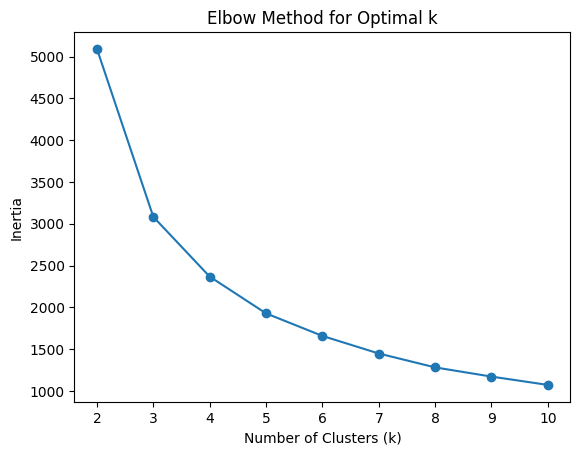

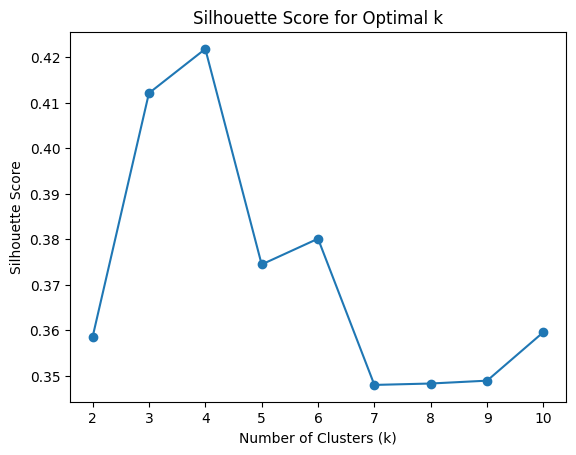

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Range of k values
k_values = range(2, 11)

# Lists to store evaluation metrics
inertia_values = []
silhouette_scores = []

# Calculate metrics for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_features)  # scaled_features is my pre-scaled data
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot Inertia
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Plot Silhouette Score
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

## **Yearly** **Revenue**

In [ ]:
#Revenue by Year
yearly_sales=sales.groupby(['YEAR_ID'])[['SALES']].sum(numeric_only=True).reset_index()
yearly_sales

,YEAR_ID,SALES
0,2003,3516979.54
1,2004,4724162.60
2,2005,1791486.71


<ipython-input-130-08ce61a3abd9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(yearly_sales, x='YEAR_ID', y='SALES', palette='pastel')


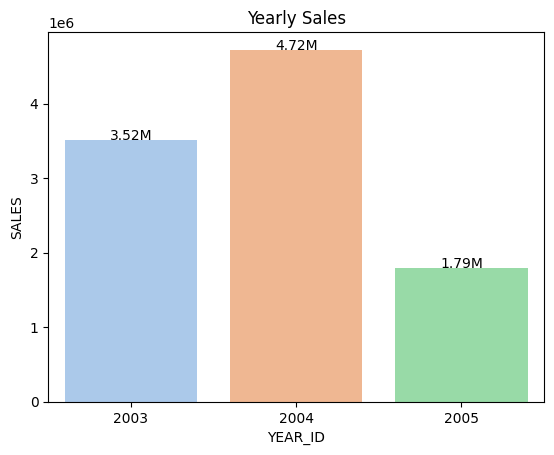

In [ ]:
#Plot the revenue by year
plt.title('Yearly Sales')
ax=sns.barplot(yearly_sales, x='YEAR_ID', y='SALES', palette='pastel')
labels=[f'{value/1e6:.2f}M' for value in yearly_sales['SALES']]

# Iterate through patches (bars) and add labels
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, labels[i], ha="center")

plt.show()

## **Overall country sales in each year**

In [ ]:
#Overall country sales in each year
yearly_sales_by_country=sales.groupby(['COUNTRY', 'YEAR_ID'])[['SALES']].sum().reset_index()

yearly_sales_by_country.head(50)

,COUNTRY,YEAR_ID,SALES
0,AUSTRALIA,2003,253134.45
1,AUSTRALIA,2004,232396.68
2,AUSTRALIA,2005,145091.97
3,AUSTRIA,2003,82117.88
4,AUSTRIA,2004,51694.39
5,AUSTRIA,2005,68250.26
6,BELGIUM,2003,3348.46
7,BELGIUM,2004,80024.05
8,BELGIUM,2005,25040.11
9,CANADA,2003,54609.50


<ipython-input-138-a70c3653bdc5>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xlabels, rotation=90)


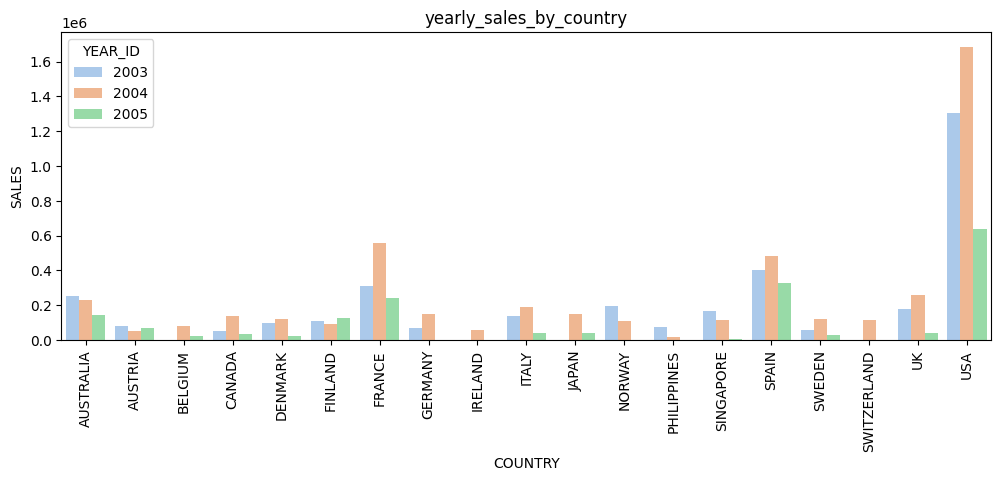

In [ ]:
#Plot the revenue by year and country
plt.figure(figsize=(12,4))
plt.title('yearly_sales_by_country')
ax=sns.barplot(yearly_sales_by_country, x='COUNTRY', y='SALES',hue='YEAR_ID', palette='pastel')
xlabels=list(yearly_sales_by_country['COUNTRY'].unique())
ax.set_xticklabels(labels=xlabels, rotation=90)
plt.show()

### **Observations**:
> 1. Through the graph, 2004 has the highest revenue among 3 years ( however 2005 has only 5 months data, we will talk about it later)
> 2. USA is the top contribution, France and Spain seems very close, they shall be the 2nd and 3rd, we can look closer later


###**Monthly** **Revenue** **Trend**

<ipython-input-142-6f2a6efc4994>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order)


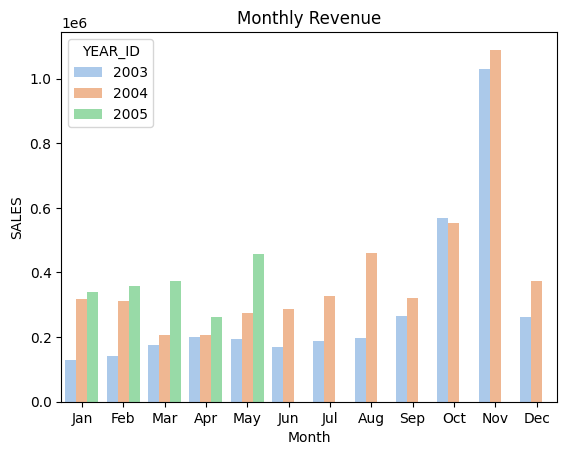

In [ ]:
#Revenue by month
order=['Jan','Feb', 'Mar','Apr','May','Jun','Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec']

monthly_revenue=sales.groupby(['MONTH_ID', 'YEAR_ID'])[['SALES']].sum().reset_index()
ax=sns.barplot(data=monthly_revenue, x='MONTH_ID', y='SALES', hue='YEAR_ID', palette='pastel')
plt.title('Monthly Revenue')
ax.set_xlabel('Month')
ax.set_xticklabels(order)
plt.show()

##**Analysis of Product line and Shipping Status**

<ipython-input-145-5e9ba62ff0f0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=data[colname1], y=data[colname2], palette='Paired', **kwargs)


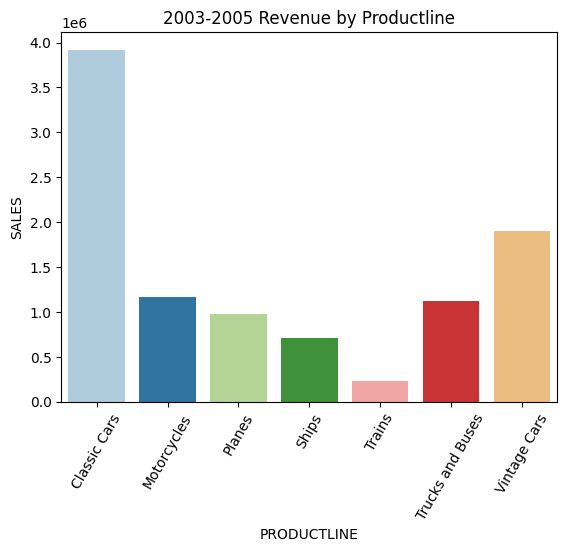

In [ ]:
def barplotter(data, colname1, colname2, title, **kwargs):
    plt.title(title)
    sns.barplot(data=data, x=data[colname1], y=data[colname2], palette='Paired', **kwargs)
    plt.xticks(rotation=60)

# Plot each productline sales
sales_by_productline=sales.groupby(['PRODUCTLINE'])[['SALES']].sum().reset_index()
barplotter(data=sales_by_productline, colname1='PRODUCTLINE', colname2='SALES', title='2003-2005 Revenue by Productline',errorbar=None)

## **Deal Size by Country**

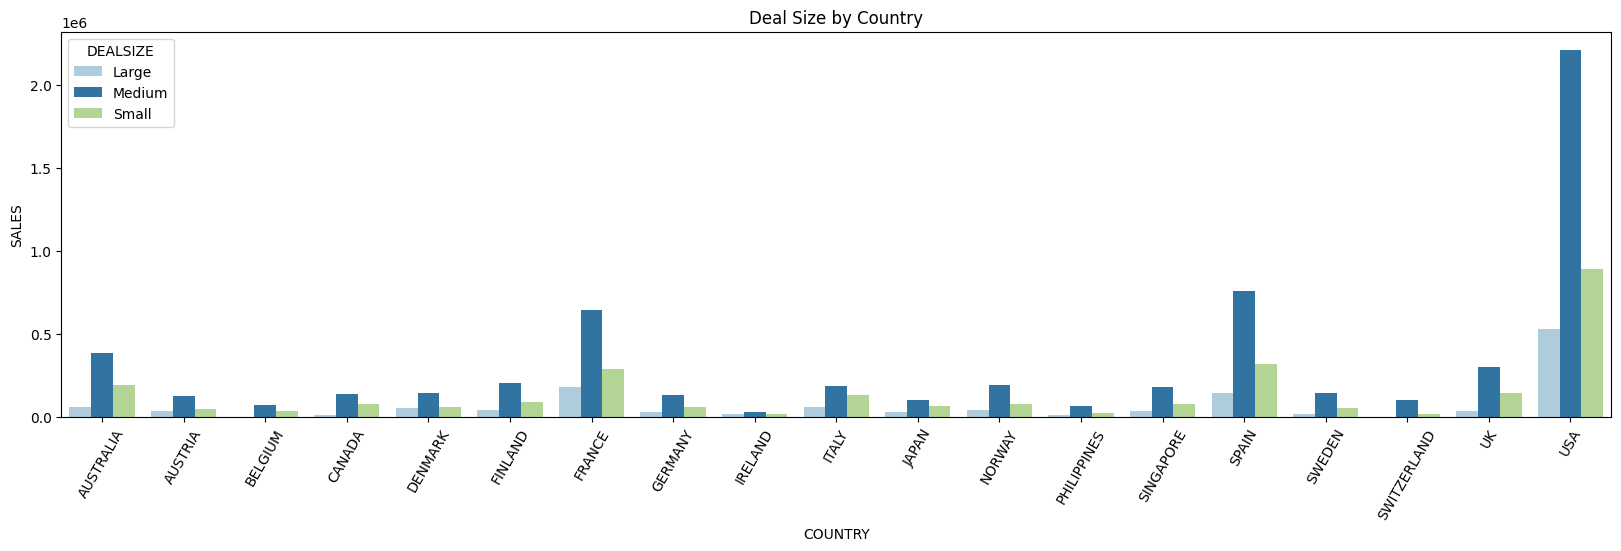

In [ ]:
#Product line by country
countrysales_by_productline=sales.groupby(['COUNTRY', 'DEALSIZE'])[['SALES']].sum().reset_index()
countrysales_by_productline
#Plot Countrysales by productline
plt.figure(figsize=(20, 5))
barplotter(data=countrysales_by_productline, colname1='COUNTRY', colname2='SALES', title='Deal Size by Country', hue=countrysales_by_productline['DEALSIZE'])